<a href="https://colab.research.google.com/github/skanelo/Deep-Emotion-Recognition/blob/main/Deep_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Emotion Recognition system that bases its predictions on facial expressions

### Import the necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
plt.rc('font',family='Times New Roman') 

In [41]:
# some colors
r_hex= '#dc2624'# red, RGB = 220,38,36 
dt_hex= '#2b4750'# dark teal, RGB = 43,71,80 
tl_hex= '#45a0a2'# teal, RGB = 69,160,162 
r1_hex= '#e87a59'# red, RGB = 232,122,89 
tl1_hex= '#7dcaa9'# teal, RGB = 125,202,169 
g_hex= '#649E7D'# green, RGB = 100,158,125 
o_hex= '#dc8018'# orange, RGB = 220,128,24 
tn_hex= '#C89F91'# tan, RGB = 200,159,145 
g50_hex= '#6c6d6c'# grey-50, RGB = 108,109,108 
bg_hex= '#4f6268'# blue grey, RGB = 79,98,104 
g25_hex= '#c7cccf'# grey-25, RGB = 199,204,207
queen_blue = '#406E8E'
light_cyan = '#CBF7ED'
cadet_grey = '#8EA8C3'
prussian_blue = '#23395B'

### Load and preprocess the data
##### 将八类数据合并成3大类 pos neg neu

In [166]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data, mode='Train'):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    # fig, ax = plt.subplots(figsize=(9, 5))
    fig, ax = plt.subplots(figsize=(4, 5))
    # ax.bar(classes, data, color=dt_hex)
    ax.bar(classes, data, color=tl_hex)
    ax.set(title=f"{mode} dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="Number of Images")
    ax.grid()
    plt.savefig(f'/result/3-classify/{mode}_data_distribution.eps', format='eps', dpi=1000)
    plt.savefig(f'/result/3-classify/{mode}_data_distribution.png')
    # plt.show()


def load_data(data_path, mode='Train'):
    """
    Load the dataset to the memory.

    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts

    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img ) # (48,48,3)
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC) # (48,48,3)
        
            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    data = np.array(img_data_list)
    le = LabelEncoder()
    labels = le.fit_transform(labels_list)

    # labels = to_categorical(labels, 6)
    labels = to_categorical(labels, 3)

    data_visualization(subfolders_ck, num_images_per_class, mode=mode)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 7287 images of category Positive
Loading : 9033 images of category Negtive
Loading : 8740 images of category Neutral

Total number of uploaded data:  25060 , with data shape (48, 48, 3)


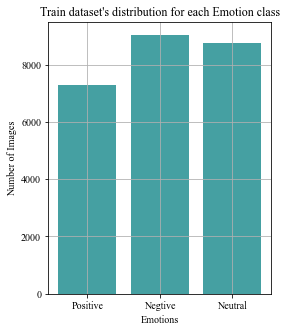

In [170]:
# data_path_ck = "/dataset/CK+48"
# data, labels = load_data(data_path_ck)
data_path_fer_train = '/dataset/ferplus_3/Training'
X_train, y_train = load_data(data_path_fer_train, mode='Train')

[INFO] Dataset Loading...

Loading : 865 images of category Positive
Loading : 1152 images of category Negtive
Loading : 1182 images of category Neutral

Total number of uploaded data:  3199 , with data shape (48, 48, 3)


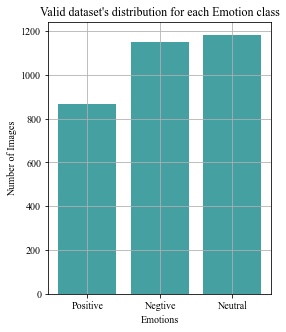

In [16]:
data_path_fer_valid = '/dataset/ferplus_3/PublicTest'
X_valid, y_valid = load_data(data_path_fer_valid, mode='Valid')

[INFO] Dataset Loading...

Loading : 893 images of category Positive
Loading : 1170 images of category Negtive
Loading : 1090 images of category Neutral

Total number of uploaded data:  3153 , with data shape (48, 48, 3)


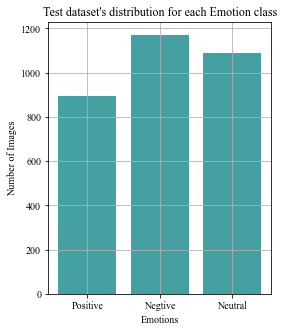

In [218]:
data_path_fer_test = '/dataset/ferplus_3/PrivateTest'
X_test, y_test = load_data(data_path_fer_test, mode='Test')

In [18]:
# Split the dataset into two subsets (70%-30%). The first one will be used for training.
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=3)
print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")
# The second subset will be split into validation and test set (50%-50%).
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)
print(f"X_valid has shape: {X_valid.shape}")
print(f"y_valid has shape: {y_valid.shape}\n")
print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")
print(f"X_train + X_valid + X_test = {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (25060, 48, 48, 3)
y_train has shape: (25060, 3)

X_valid has shape: (3199, 48, 48, 3)
y_valid has shape: (3199, 3)

X_test has shape: (3153, 48, 48, 3)
y_test has shape: (3153, 3)

X_train + X_valid + X_test = 31412 samples in total


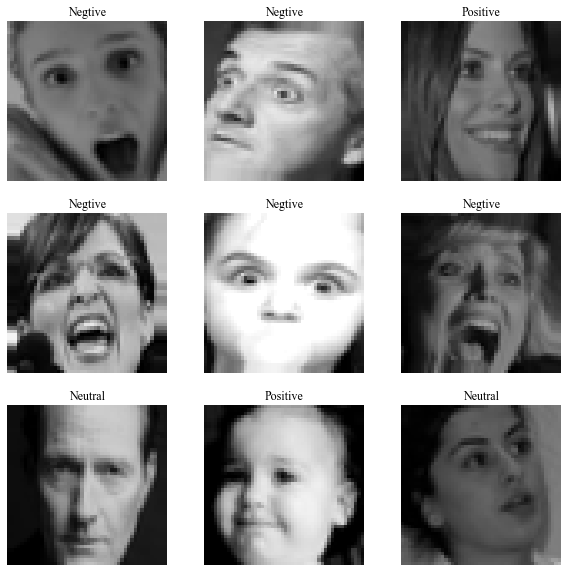

In [20]:
# Map the emotion-categories
# mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprised', 6:'normal'}
# mapping = {0:'anger', 1:'contempt', 2:'disgust', 3:'fear', 4:'happy', 5:'neutral', 6:'sadness', 7:'surprise'}
mapping = {0:'Negtive', 1:'Neutral', 2:'Positive'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")
plt.savefig('/result/3-classify/sample_plot.eps', format='eps', dpi=1000)
plt.savefig('/result/3-classify/sample_plot.png')
# plt.show()

### Create the model

In [21]:
def build_model():
    """
    Create the new model.
  
    This function loads a pre-trained EfficientNetB0 model on Imagenet,
    adds an Input layer at the beggining, and 3 more layers at the end
    (i.e GlobalAveragePooling2D, Dropout, Dense).

    Args:
        No value
   
    Returns:
        model (tensorflow.python.keras.engine.functional.Functional): The compiled model
    """
    
    inputs = Input(shape=(48, 48, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet',
                                drop_connect_rate=0.33, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.1, name="top_dropout")(x)
    # outputs = Dense(6, activation='softmax')(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [22]:
# Create an object of the model
model = build_model()

2022-01-28 14:21:24.893932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 14:21:25.026507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd94c7f9730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-28 14:21:25.026743: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### Save the summary and the plot of the model into files

In [23]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#print(model.summary())
# plot_model(model, to_file='model.png')

### Train the model

In [25]:
EPOCHS = 100
batch_size = 32
filepath = "/checkpoint/ferplus_3.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100
783/783 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.7857
Epoch 00001: val_accuracy improved from -inf to 0.81619, saving model to /Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_3.hdf5
783/783 [==============================] - 400s 511ms/step - loss: 0.5101 - accuracy: 0.7857 - val_loss: 0.4551 - val_accuracy: 0.8162
Epoch 2/100
783/783 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.7971
Epoch 00002: val_accuracy improved from 0.81619 to 0.83151, saving model to /Users/gengyunxin/Documents/研究生/ICALT/checkpoint/ferplus_3.hdf5
783/783 [==============================] - 301s 384ms/step - loss: 0.4723 - accuracy: 0.7971 - val_loss: 0.4123 - val_accuracy: 0.8315
Epoch 3/100
783/783 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8167
Epoch 00003: val_accuracy did not improve from 0.83151
783/783 [==============================] - 261s 333ms/step - los

### Plot the learning curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


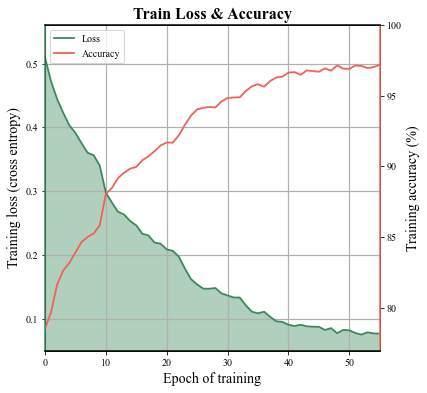

In [201]:
unbleached_silk = '#FFD8BE'
pine_green = '#0B7A75'
falu_red = '#7B2D26'
sea_green = '#3E885B'
eton_blue = "#85BDA6"
fire_opal = '#F26157'
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(hist.history['loss'], color=sea_green, label='Loss', linewidth=1.8, linestyle='-')
# ax1.legend(loc='upper left')
ax1.set_ylim(0.05, np.array(hist.history['loss']).max()*1.1)
ax1.set_xlim(0, len(hist.history['loss'])-1)
ax1.set_xlabel('Epoch of training', fontsize=14)
ax1.set_ylabel('Training loss (cross entropy)', fontsize=14)
ax1.grid(linewidth=1.2)

ax1.fill_between(list(np.array([i for i in range(len(hist.history['loss']))])), 0, hist.history['loss'], facecolor=sea_green, alpha=0.4)

ax2 = ax1.twinx()
ax2.plot([i*100 for i in hist.history['accuracy']], color=fire_opal, label='Accuracy', linewidth=1.8, linestyle='-')
# ax2.legend(loc='upper right')
ax2.set_ylim(np.array(hist.history['accuracy']).min()*0.98*100, 100)
ax2.set_ylabel('Training accuracy (%)', fontsize=14)
# ax2.fill_between(list(np.array([i for i in range(len(hist.history['loss']))])), 0, hist.history['accuracy'], facecolor=fire_opal, alpha=0.4)

# fig.legend(loc='upper right')
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes, fontsize=10)
plt.title('Train Loss & Accuracy', fontsize=16, weight='bold')
# plt.grid()

ax = plt.gca() # 获取当前的axes
ax.spines['right'].set_color(fire_opal)
ax.spines['left'].set_color(sea_green)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.savefig('/result/Loss&Acc_3.png')
plt.savefig('/result/Loss&Acc_3.eps', format='eps', dpi=100)

# Load the weights with which the model managed to achieve the highest validation accuracy

In [27]:
model.load_weights('/checkpoint/ferplus_3.hdf5')

### Pick randomly some images that the model hasn't seen yet and let it predict. The barplot on the write shows the confidence of its prediction

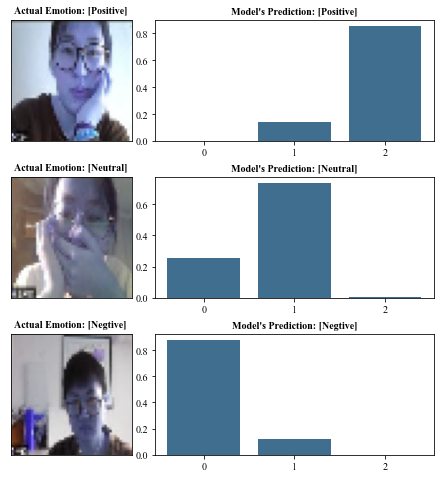

In [215]:
samples = np.random.choice(len(X_test), 3)

predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(9, 8))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Emotion: [{mapping[np.argmax(label)]}]', weight='bold', fontsize=10)

    axes[i, 1].bar(np.arange(len(prediction)), prediction, color=queen_blue)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold', fontsize=10)
plt.savefig('/result/3-classify/test500.png')
plt.savefig('/result/3-classify/test500.eps', format='eps', dpi=500)

In [219]:
def show_confusion_matrix(X_test, y_test):
    """
    Show the confusion matrix of the unseen data.
  
    This function takes a fraction of the dataset that has not seen yet and
    tries to categorize each image into one of the 6 classes. The results are
    represented through a confusion matrix.

    Args:
        X_test (numpy.ndarray): unseen images
        y_test (numpy.ndarray): their corresponding labels
   
    Returns:
        No value
    """

    # Predict the test set (the system hasn't seen it yet)
    predictions = model.predict(X_test, verbose=0)
    
    y_classes =  np.argmax(predictions, axis=1)
    actual_classes =  np.argmax(y_test, axis=1)

    pred_labels = [mapping[element] for element in y_classes]
    actual_labels = [mapping[element] for element in actual_classes]

    # Create a dictionary
    data = {'y_Actual':    actual_labels,
            'y_Predicted': pred_labels}

    # Create a dataframe
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    # Calculate model's accuracy
    correct_predictions = sum(map(lambda x, y: x == y, pred_labels, actual_labels))
    all_samples = len(y_test)
    print(f"Final accuracy: {correct_predictions/all_samples * 100:.2f}%")

    # Plot the confusion matrix
    _, ax = plt.subplots(figsize=(6,5)) 
    sn.heatmap(confusion_matrix, annot = True, ax=ax)
    plt.savefig('/result/3-classify/confusion_matrix.png')
    plt.savefig('/result/3-classify/confusion_matrix.eps', format='eps', dpi=500)
    plt.show()

Final accuracy: 87.60%


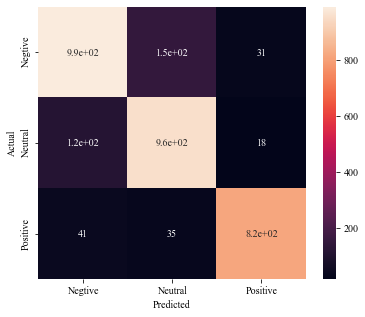

In [220]:
show_confusion_matrix(X_test, y_test)

In [176]:
def load_test_data(data_path, mode='Test'):
    """
    Load the dataset to the memory.

    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts

    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            print(data_path + '/'+ category + '/'+ img)
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            # gray = cv2.cvtColor(pixels, cv2.COLOR_BGR2GRA
            print(pixels.shape)
            face_array=cv2.resize(pixels, (48,48), interpolation = cv2.INTER_CUBIC)
        
            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    data = np.array(img_data_list)
    le = LabelEncoder()
    labels = le.fit_transform(labels_list)

    # labels = to_categorical(labels, 6)
    labels = to_categorical(labels, 3)

    data_visualization(subfolders_ck, num_images_per_class, mode=mode)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 1 images of category Positive
/dataset/test/tt/Positive/WechatIMG825.png
(238, 356, 3)
Loading : 1 images of category Negtive
/dataset/test/tt/Negtive/WechatIMG828.png
(228, 354, 3)
Loading : 1 images of category Neutral
/dataset/test/tt/Neutral/WechatIMG831.png
(236, 358, 3)

Total number of uploaded data:  3 , with data shape (48, 48, 3)


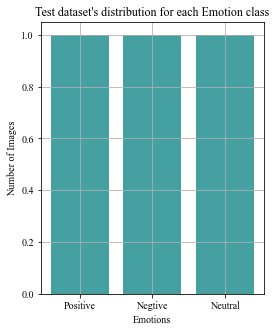

In [204]:
data_path_test = '/dataset/test/tt'
X_test, y_test = load_test_data(data_path_test, mode='Test')

In [ ]:
|